# Worked examples with Ag 1000 Genomes data

### Preamble

In [1]:
library(h5)
library(ggplot2)

In [2]:
sessionInfo()

R version 3.2.2 (2015-08-14)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 14.04.3 LTS

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_1.0.1 h5_0.9.6     

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.4          digest_0.6.8         MASS_7.3-44         
 [4] IRdisplay_0.3.0.9000 plyr_1.8.3           repr_0.4            
 [7] grid_3.2.2           jsonlite_0.9.17      gtable_0.1.2        
[10] magrittr_1.5         scales_0.3.0         evaluate_0.8        
[13] stringi_0.5-5        reshape2_1.4.1       uuid_0.1-2     

In [3]:
# specify filename
fn <- "/home/ag1000g.phase1.ar3.pass.3L.h5"

In [4]:
# create the filehandle to access the data
fh <- h5file(fn, "r")

In [5]:
list.datasets(fh)

[1] "/3L/calldata/AD"                    "/3L/calldata/DP"                   
 [3] "/3L/calldata/GQ"                    "/3L/calldata/genotype"             
 [5] "/3L/calldata/is_called"             "/3L/samples"                       
 [7] "/3L/variants/ABHet"                 "/3L/variants/ABHom"                
 [9] "/3L/variants/AC"                    "/3L/variants/AF"                   
[11] "/3L/variants/ALT"                   "/3L/variants/AN"                   
[13] "/3L/variants/ANN"                   "/3L/variants/Accessible"           
[15] "/3L/variants/BaseCounts"            "/3L/variants/BaseQRankSum"         
[17] "/3L/variants/CHROM"                 "/3L/variants/Coverage"             
[19] "/3L/variants/CoverageMQ0"           "/3L/variants/DP"                   
[21] "/3L/variants/DS"                    "/3L/variants/Dels"                 
[23] "/3L/variants/FILTER_FS"             "/3L/variants/FILTER_HRun"          
[25] "/3L/variants/FILTER_HighCoverage"   "/3L/variants/FILTER_HighMQ0"       
[27] "/3L/variants/FILTER_LowCoverage"    "/3L/variants/FILTER_LowMQ"         
[29] "/3L/variants/FILTER_LowQual"        "/3L/variants/FILTER_NoCoverage"    
[31] "/3L/variants/FILTER_PASS"           "/3L/variants/FILTER_QD"            
[33] "/3L/variants/FILTER_ReadPosRankSum" "/3L/variants/FILTER_RefN"          
[35] "/3L/variants/FILTER_RepeatDUST"     "/3L/variants/FS"                   
[37] "/3L/variants/HRun"                  "/3L/variants/HW"                   
[39] "/3L/variants/HaplotypeScore"        "/3L/variants/HighCoverage"         
[41] "/3L/variants/HighMQ0"               "/3L/variants/InbreedingCoeff"      
[43] "/3L/variants/LOF"                   "/3L/variants/LowCoverage"          
[45] "/3L/variants/LowMQ"                 "/3L/variants/LowPairing"           
[47] "/3L/variants/MLEAC"                 "/3L/variants/MLEAF"                
[49] "/3L/variants/MQ"                    "/3L/variants/MQ0"                  
[51] "/3L/variants/MQRankSum"             "/3L/variants/NDA"                  
[53] "/3L/variants/NMD"                   "/3L/variants/NoCoverage"           
[55] "/3L/variants/OND"                   "/3L/variants/POS"                  
[57] "/3L/variants/QD"                    "/3L/variants/QUAL"                 
[59] "/3L/variants/REF"                   "/3L/variants/RPA"                  
[61] "/3L/variants/RU"                    "/3L/variants/ReadPosRankSum"       
[63] "/3L/variants/RefMasked"             "/3L/variants/RefN"                 
[65] "/3L/variants/RepeatDUST"            "/3L/variants/RepeatMasker"         
[67] "/3L/variants/RepeatTRF"             "/3L/variants/STR"                  
[69] "/3L/variants/VariantType"           "/3L/variants/is_snp"               
[71] "/3L/variants/num_alleles"           "/3L/variants/svlen"

In [6]:
# sample names are stored in the first level after chromosome
samples <- fh["/3L/samples"]
samples

DataSet 'samples' (765)
type: character
chunksize: NA
maxdim: 765

In [7]:
samples[1:20]

[1] "AB0085-C" "AB0087-C" "AB0088-C" "AB0089-C" "AB0090-C" "AB0091-C"
 [7] "AB0092-C" "AB0094-C" "AB0095-C" "AB0097-C" "AB0098-C" "AB0099-C"
[13] "AB0100-C" "AB0101-C" "AB0103-C" "AB0104-C" "AB0109-C" "AB0110-C"
[19] "AB0111-C" "AB0112-C"

In [8]:
# positions are stored in the "variants" group
fh["/3L/variants/POS"]

DataSet 'POS' (9.6432e+06)
type: integer
chunksize: 32768
maxdim: UNLIMITED
compression: H5Z_FILTER_DEFLATE

In [9]:
## Function to apply a function f, to values based on windows of positions
# NOTE: The final incomplete window is not included
windowed_analysis <- function(positions, values, f, win_size=100000, ...){

    windows <- seq(0, positions[attr(positions, "dim")], by=100000)
    ix = findInterval(windows, positions[], all.inside=TRUE)
    x = rep(NA, length(windows) - 1)

    for (i in 1:(length(ix)-1)){
        start = ix[i]
        stop  = ix[i + 1]

        v = values[start:stop]
        x[i] = f(v, ...)
    }
    return (data.frame("values"=x,
                       "start"=windows[1:length(windows) -1],
                       "stop"=windows[2:length(windows)]))
}

# Plot mean mq0 in windows across the genome

In [10]:
mq0_variants <- windowed_analysis(fh["/3L/variants/POS"], 
                                  fh["/3L/variants/CoverageMQ0"], 
                                  mean)

# use the midpoint of the window instead of the start/stop
mq0_variants$position <- with(mq0_variants, (start + stop)/2)

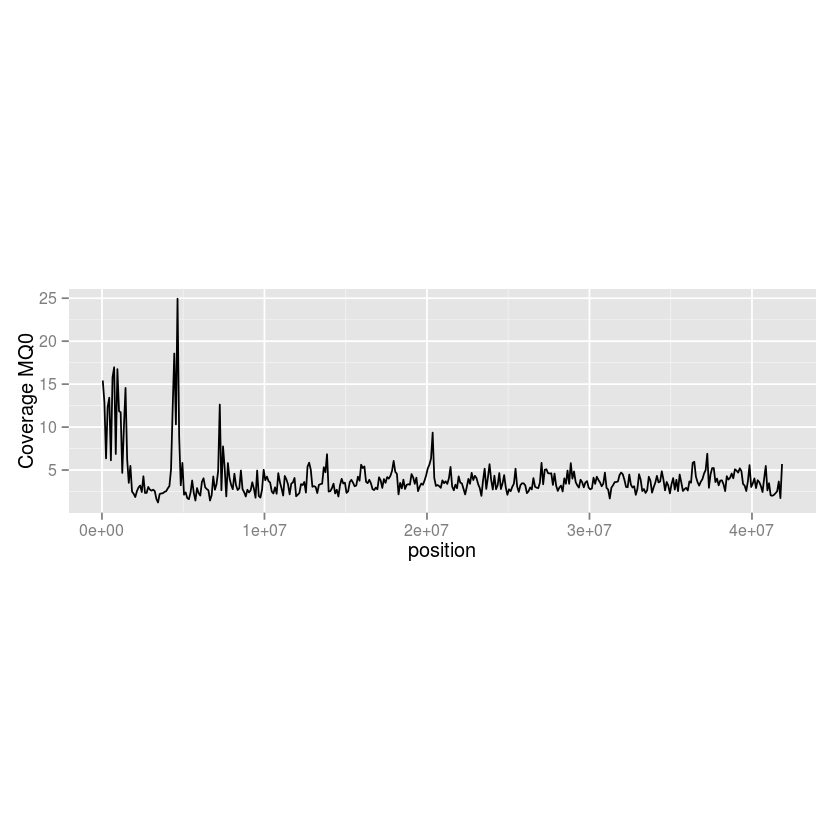

In [11]:
# plot in windows
p <- ggplot(mq0_variants, aes(x=position, y=values)) + ylab("Coverage MQ0")
p + geom_line() + theme(aspect.ratio=0.3)

## Plot count of variants across the genome

NOTE: Accessibility likely to differ between windows, so this is a combined measure of accessibility and diversity

In [12]:
# as we are just taking the length use pos as the values
count_variants <- windowed_analysis(fh["/3L/variants/POS"], 
                                    fh["/3L/variants/POS"], 
                                    length)

In [13]:
count_variants$position <- with(count_variants, (start + stop)/2)

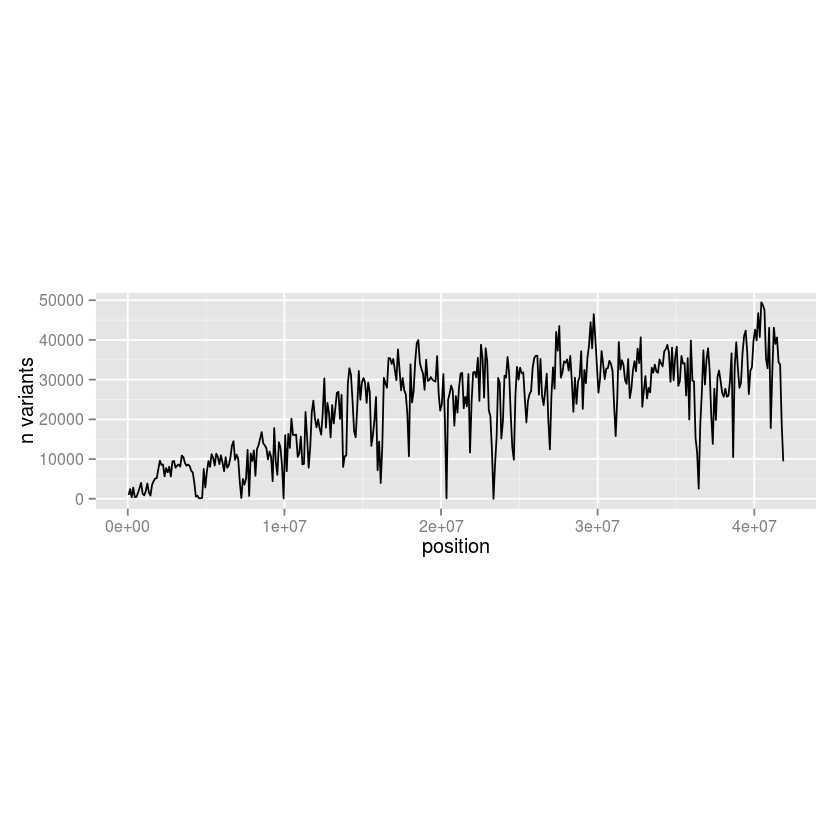

In [14]:
# plot in windows
p <- ggplot(count_variants, aes(x=position, y=values)) + ylab("n variants")

p + geom_line() + theme(aspect.ratio=0.3)

# Calculate Fst between two populations

For this we will need some metadata.

We compute the allele counts and use these to calculate Fst. 

In [15]:
install.packages("BEDASSLE", repos="https://www.stats.bris.ac.uk/R", 
                 lib="/usr/local/lib/R/site-library")
library(BEDASSLE)


The downloaded source packages are in
	‘/tmp/RtmpKvunCW/downloaded_packages’


In [16]:
# read in the metadata file
metadata <- read.table("/home/samples.meta.txt",
                       sep="\t", header=TRUE, stringsAsFactors=FALSE, quote="")

In [17]:
head(metadata[,1:5])

,index,ox_code,src_code,sra_sample_accession,population
1,0,AB0085-C,BF2-4,ERS223996,BFS
2,1,AB0087-C,BF3-3,ERS224013,BFM
3,2,AB0088-C,BF3-5,ERS223991,BFM
4,3,AB0089-C,BF3-8,ERS224031,BFM
5,4,AB0090-C,BF3-10,ERS223936,BFM
6,5,AB0091-C,BF3-12,ERS224065,BFM


In [18]:
# calculate windowed fst using weir and hill
# This function could be generalized by passing a function that operated on dA and dB
calculate_windowed_fst <- function(data, chrom, popA_ix, popB_ix, window_size=100000, 
                                   start=NULL, stop=NULL){
    
    positions <- data[gsub("chrom", chrom, "/chrom/variants/POS")]
    
    if (is.null(start)){
        start = 0
    }
    
    if (is.null(stop)){
        stop <- positions[attr(positions, "dim")]
    }
    
    windows <- seq(start, stop, by=window_size)
    ix = findInterval(windows, positions[], all.inside=TRUE)
    fst = rep(NA, length(windows) - 1)
    time_load = rep(NA, length(windows) - 1)
    time_stat = rep(NA, length(windows) - 1)

    for (i in 1:(length(ix)-1)){
        begin = ix[i]
        end  = ix[i + 1]
        
        num_alleles = data[gsub("chrom", chrom, "/chrom/variants/num_alleles")][begin:end]
        ok <- num_alleles <= 2
        
        # don't calculate on a single SNP
        if (sum(ok) < 2){
            next()
        }
                
        # only biallelic
        load_time <- system.time({
            dA <- data[gsub("chrom", chrom, "/chrom/calldata/genotype")][begin:end, popA_ix, 1:2]
            dA <- dA[ok,,]
            
            dB <- data[gsub("chrom", chrom, "/chrom/calldata/genotype")][begin:end, popB_ix, 1:2]
            dB <- dB[ok,,]
        })
        time_load[i] = load_time["elapsed"][[1]]
        
        stat_time <- system.time({
        
            allele_counts = matrix(NA, nrow=2, ncol=sum(ok))
            allele_counts[1,] = apply(dA, MARGIN=1, FUN=function(x) { sum(x > 0)})
            allele_counts[2,] = apply(dB, MARGIN=1, FUN=function(x) { sum(x > 0)})
            
            alleles_typed = matrix(NA, nrow=2, ncol=sum(ok))
            alleles_typed[1,] = apply(dA, MARGIN=1, FUN=function(x) { sum(x >= 0)})
            alleles_typed[2,] = apply(dB, MARGIN=1, FUN=function(x) { sum(x >= 0)})
            
            fst[i] = calculate.pairwise.Fst(allele.counts=allele_counts,
                                            sample.sizes=alleles_typed)

        })
        time_stat[i] = stat_time["elapsed"][[1]]
    }
    
    return (data.frame("Fst"=fst,
                       "start"=windows[1:length(windows) -1],
                       "stop"=windows[2:length(windows)],
                       "time_load"=time_load,
                       "time_stat"=time_stat))
}

In [19]:
# find the indices of the Burkina Faso S and M samples
bfs_ix = which(metadata$population == "BFS")
bfm_ix = which(metadata$population == "BFM")

In [20]:
# slow ish: ~11 minutes for the who chromosome arm
fst <- calculate_windowed_fst(fh, "3L", bfs_ix, bfm_ix, start=NULL, stop=NULL)

In [21]:
fst$position <- with(fst, (start + stop)/2)

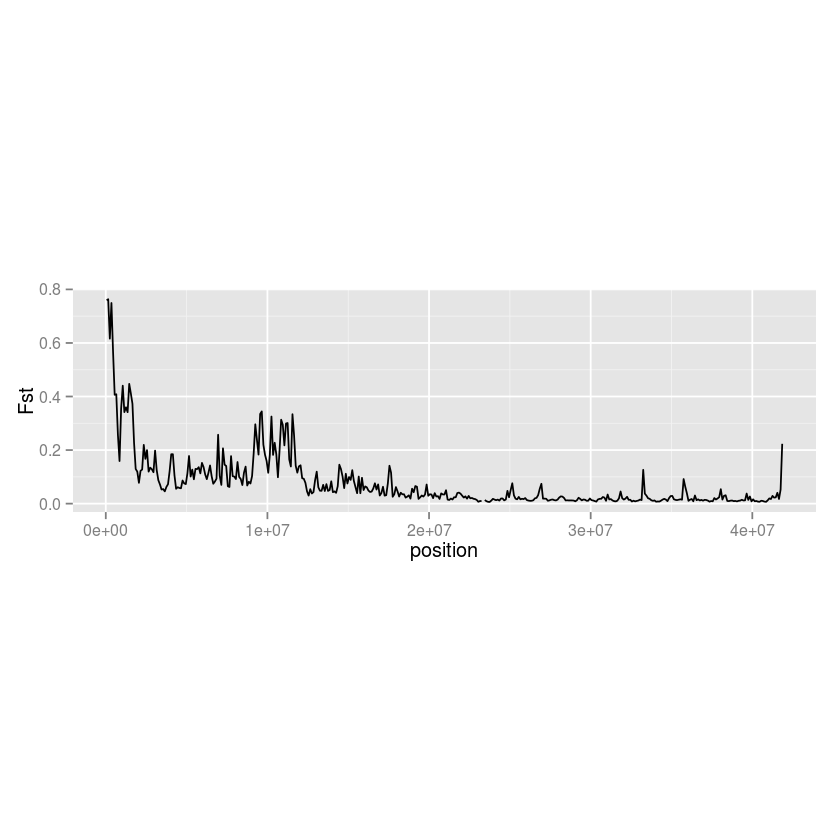

In [22]:
p <- ggplot(fst, aes(x=position, y=Fst))
p + geom_line() + theme(aspect.ratio=0.3)

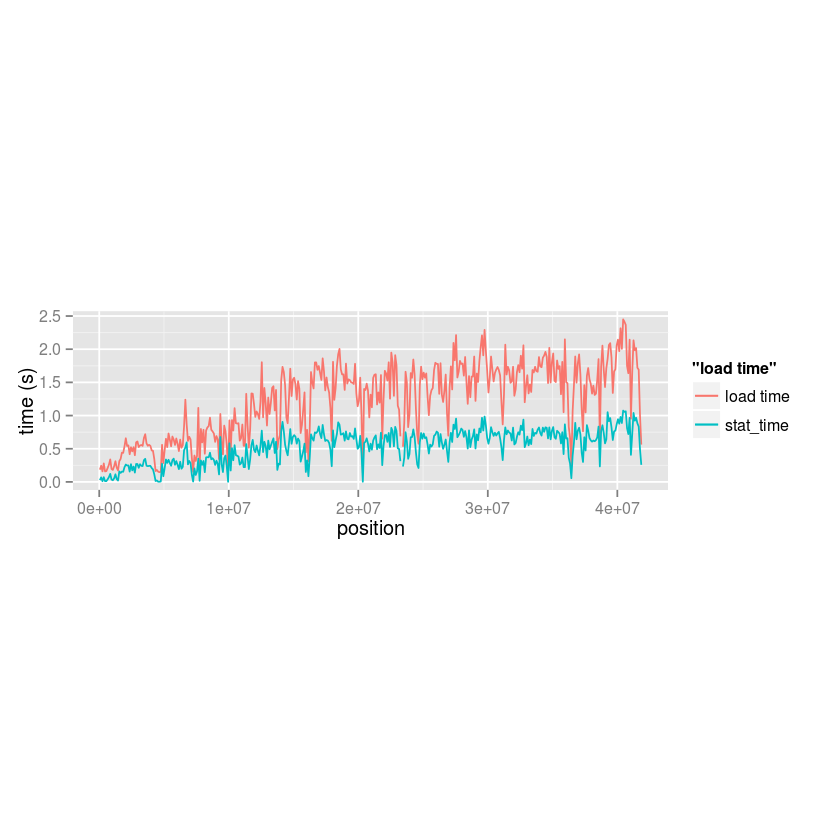

In [23]:
# Plot time taken for each window to see which part is slow
p <- ggplot(fst, aes(x=position, y=time_load, color="load time")) + ylab("time (s)")
p <- p + geom_line() + theme(aspect.ratio=0.3)
p + geom_line(data=fst, aes(x=position, y=time_stat, color="stat_time"))

In [24]:
# sum the output array to give the final time load and time stat
apply(fst, MARGIN=2, sum, na.rm=T)

Fst        start         stop    time_load    time_stat     position 
3.199535e+01 8.757100e+09 8.799000e+09 5.131030e+02 2.226520e+02 8.778050e+09

# Plot hz in a KES sample vs CMS sample

In [25]:
# choose the first sample of each pop
sample_kes = match("KES", metadata$population)
sample_cms = match("CMS", metadata$population)

In [26]:
# what numbers of samples did we pick?
print(c(sample_kes, sample_cms))

[1] 300 344


In [27]:
## Function to apply a function f, to values based on windows of positions
# and a single sample index
# NOTE: The final incomplete window is not included
windowed_analysis_3D <- function(positions, values, sample_ix, f, 
                                 win_size=100000, ...){

    #windows <- seq(0, 500000, by=100000)
    windows <- seq(0, positions[attr(positions, "dim")], by=100000)
    ix = findInterval(windows, positions[], all.inside=TRUE)
    x = rep(NA, length(windows) - 1)
    
    for (i in 1:(length(ix)-1)){
        start = ix[i]
        stop  = ix[i + 1]

        v = values[start:stop, sample_ix, 1:2]
        #print("ok")
        x[i] = f(v, ...)
    }
    return (data.frame("values"=x,
                       "start"=windows[1:length(windows) -1],
                       "stop"=windows[2:length(windows)]))
}

In [28]:
# counts the number of hets in an individual
calc_hz <- function(x){
    
    stopifnot(length(dim(x)) == 3)
    stopifnot(dim(x)[2] == 1)
    stopifnot(dim(x)[3] == 2)

    # just return count of hz. Assumes if one allele missing, other is.
    return( sum(x[,,1] != x[,,2]) )
}

In [29]:
# kenya heterozygosity
hz_kes = windowed_analysis_3D(fh["/3L/variants/POS"], 
                              fh["/3L/calldata/genotype"], 
                              sample_ix=sample_kes, 
                              calc_hz)

In [30]:
hz_kes$position = with(hz_kes, (start + stop)/2)
hz_kes$population = "KES"

In [31]:
# cameroon
hz_cms = windowed_analysis_3D(fh["/3L/variants/POS"], 
                              fh["/3L/calldata/genotype"], 
                              sample_ix=sample_cms, 
                              calc_hz)

hz_cms$position = with(hz_cms, (start + stop)/2)
hz_cms$population = "CMS"

In [32]:
# join the outputs to make plotting easier
fst_df = rbind(hz_kes, hz_cms)

In [33]:
head(fst_df)

,values,start,stop,position,population
1,9,0,1e+05,50000,KES
2,16,1e+05,2e+05,150000,KES
3,1,2e+05,3e+05,250000,KES
4,21,3e+05,4e+05,350000,KES
5,3,4e+05,5e+05,450000,KES
6,7,5e+05,6e+05,550000,KES


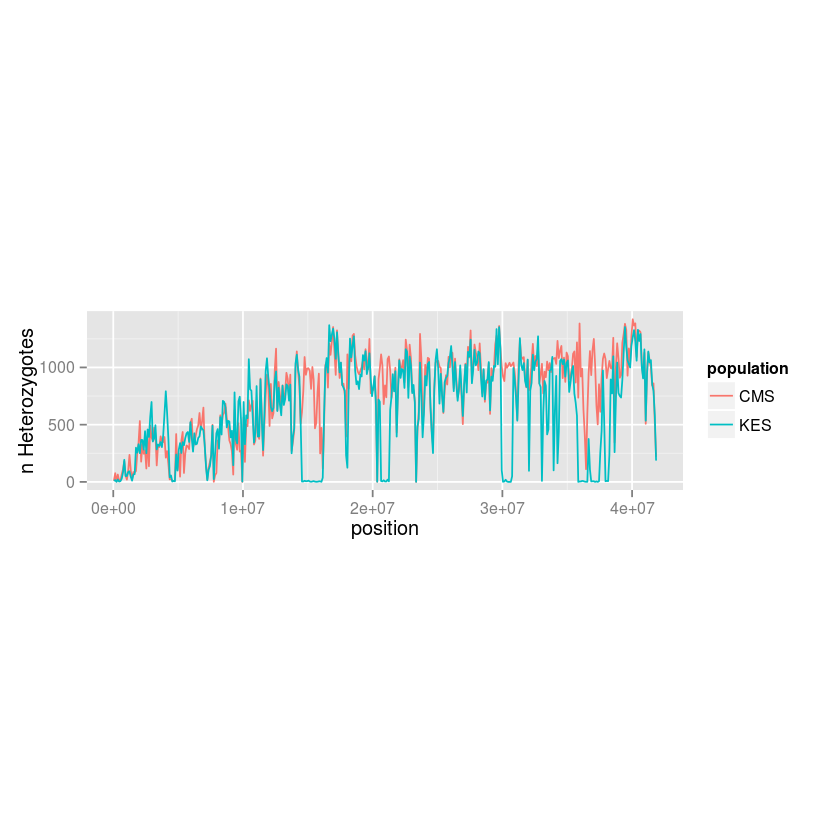

In [34]:
p <- ggplot(fst_df, aes(x=position, y=values, color=population)) + ylab("n Heterozygotes")
p <- p + geom_line() + theme(aspect.ratio=0.3)
p

# Select a gene and list the NS variants

This cannot be done in R, as the h5 library does not yet support compound data types

In [35]:
# define start/end of a gene from vectorbase
tep1 <- c(11202091, 11206882)

In [36]:
# find the start and stop indices
ix <- findInterval(tep1, fh["/3L/variants/POS"][])

In [37]:
fh["/3L/variants/ANN"][ix[1]: ix[2]]

ERROR: Error in eval(expr, envir, enclos): Reading of compound datatypes is not yet supported.


# Select a gene and find variants at > 5%

In [38]:
# read in genotypes
tep1_g = fh["/3L/calldata/genotype"][ix[1]:ix[2],,]

In [39]:
# function that given a genotype array creates an n_variants x 4 matrix of allele counts
# or of allele frequencies if freq=TRUE is passed
count_alleles <- function(geno, freq=FALSE) {
    
    n_var = dim(geno)[1]
    n_samples = dim(geno)[2]
    
    ac = matrix(0, nrow=n_var, ncol=4)
    for (i in 0:3){
        ac[, i + 1] = apply(geno, MARGIN=1, function(x) sum(x == i))
    }
    
    if (freq) {
        return (ac / apply(ac, MARGIN=1, sum))
    } else {
        return(ac)
    }
}

In [40]:
# use above function
allele_count = count_alleles(tep1_g, TRUE)

In [41]:
# minor allele frequencies are calculated
maf <- 1 - apply(allele_count, MARGIN=1, max)

In [42]:
# display positions within the gene that are also >5% MAF
fh["/3L/variants/POS"][ix[1]:ix[2]][maf > 0.05]

[1] 11204271 11204298 11204330 11204373 11204436 11204442 11204659 11205025
 [9] 11205026 11205037